In [2]:
import numpy as np
import math
import operator
import networkx as nx
from itertools import permutations
import matplotlib.pyplot as plt
from deap import creator, base, tools, algorithms,gp
import dimod
import dwave_networkx as dnx
from operator import itemgetter
import tsplib95

In [3]:
problem = tsplib95.load('./asymmetric_problems/ft70.atsp')
# problem = tsplib95.load('./symmetric_problems/berlin52.tsp')
G = problem.get_graph()
# tsp_problem = problem.as_keyword_dict()
# list(problem.get_nodes())

In [4]:
pos = nx.random_layout(G)

In [5]:
G.is_directed()

True

In [6]:
G.edges[0,1]['weight']

375

In [7]:
def plotRandomLayoutGraph(G,show_weights=False):
    pos = nx.random_layout(G)
    nx.draw(G,pos,with_labels=True)
    labels = nx.get_edge_attributes(G,'weight')
    if show_weights:
        nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)

    plt.show()

In [ ]:
plotRandomLayoutGraph(G)

In [8]:
G.edges[0,1]["weight"]

375

### DEAP EVOLUTIONARY ALGORITHMS

In [9]:
toolbox = base.Toolbox()
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

In [10]:
toolbox.register("indices", np.random.permutation, len(G.nodes))
toolbox.register("individual", tools.initIterate, creator.Individual,
                 toolbox.indices)
toolbox.register("population", tools.initRepeat, list, 
                 toolbox.individual)

In [11]:
toolbox.register("mate", tools.cxOrdered)
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.05)

In [12]:
def evaluation(individual):
    total_weights = []
    for index in range(len(individual)-1):
        total_weights.append(G.edges[individual[index],individual[index+1]]['weight'])
        
    total_weights.append(G.edges[individual[len(individual)-1],individual[0]]['weight'])
    

    
    return (sum(total_weights),)

In [13]:
def create_tour(individual):
    new_graph = nx.Graph()
    new_graphG=nx.complete_graph(len(individual))
    new_graph.clear_edges()
    for index in range(len(individual)-1):
        new_graph.add_edge(individual[index],individual[index+1])
    new_graph.add_edge(individual[len(individual)-1],individual[0])
    
    return new_graph

In [14]:
toolbox.register("evaluate", evaluation)

In [15]:
toolbox.register("select", tools.selTournament, tournsize=3)

In [16]:
pop = toolbox.population(n=100)

In [17]:
evaluation(pop[5])

(72802,)

In [18]:
fit_stats = tools.Statistics(key=operator.attrgetter("fitness.values"))
fit_stats.register('mean', np.mean)
fit_stats.register('min', np.min)

In [19]:
result, log = algorithms.eaSimple(pop, toolbox,
                             cxpb=0.8, mutpb=0.2,
                             ngen=400, verbose=False,stats=fit_stats)

In [20]:
best_individual = tools.selBest(result, k=1)[0]
print('Fitness of the best individual: ', evaluation(best_individual)[0])

Fitness of the best individual:  47810


In [21]:
G = create_tour(best_individual)

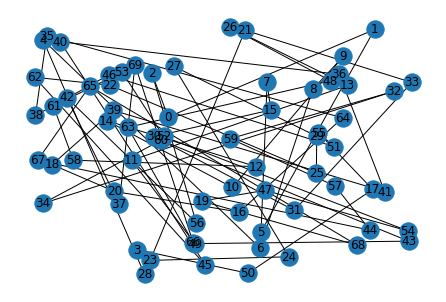

In [22]:
plotRandomLayoutGraph(G)

Text(0.5, 1.0, 'ft70 assymetric graph')

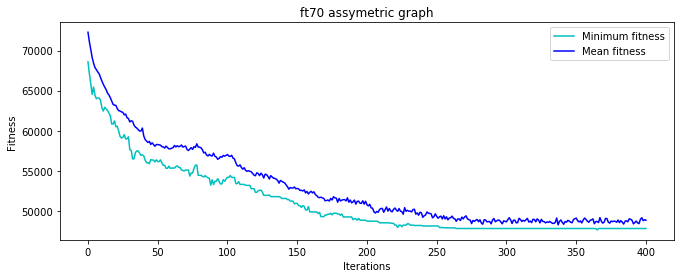

In [24]:
plt.figure(figsize=(11, 4))
plots = plt.plot(log.select('min'),'c-', log.select('mean'), 'b-')
plt.legend(plots, ('Minimum fitness', 'Mean fitness'), frameon=True)
plt.ylabel('Fitness'); plt.xlabel('Iterations');
plt.title("ft70 assymetric graph")
plt.savefig()